<a href="https://colab.research.google.com/github/nivedabhat/Introduction-to-Computer-Vision-Plant-Seedlings-Classification/blob/main/cv_project_full_code_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
# Library for creating data paths
import os
# Library for randomly selecting data points
import random
# Library for creating and showing plots
import matplotlib.pyplot as plt
# Library for reading and showing images
import matplotlib.image as mpimg
# Importing all the required sub-modules from Keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras import backend
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.callbacks import ReduceLROnPlateau
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

**Helper Functions**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels):
    num_classes = 10
    categories = np.unique(labels)
    keys = dict(labels['Label'])
    rows = 3
    cols = 4
    fig = plt.figure(figsize=(10, 8))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(labels))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.imshow(images[random_index, :])
            ax.set_title(keys[random_index])
    plt.show()

# Function to plot loss, val_loss,
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")
    plt.show()


**Loading The Datasets**

In [ ]:
# Mount Google drive to access the dataset
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Training/VisionProject/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/gdrive/MyDrive/Training/VisionProject/'
/content


In [ ]:
# Load images and labels
images = np.load('/images.npy')
labels = pd.read_csv('/Labels.csv')

**Data Overview**

**Understand the shape of the dataset**

In [ ]:

print(images.shape)

(4750, 128, 128, 3)


In [ ]:
print(labels.shape)

(4750, 1)


**Observations:**

The data contains 4750 128x128 pictures, ech with a lable

**Exploratory Data Analysis**


*   EDA is an important part of any project involving data.
*   It is important to investigate and understand the data better before building a model with
it.
*   A few questions have been mentioned below which will help you understand the data
better.
*   A thorough analysis of the data, in addition to the questions mentioned below, should be
done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
# Display Head to see what the label file looks like
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


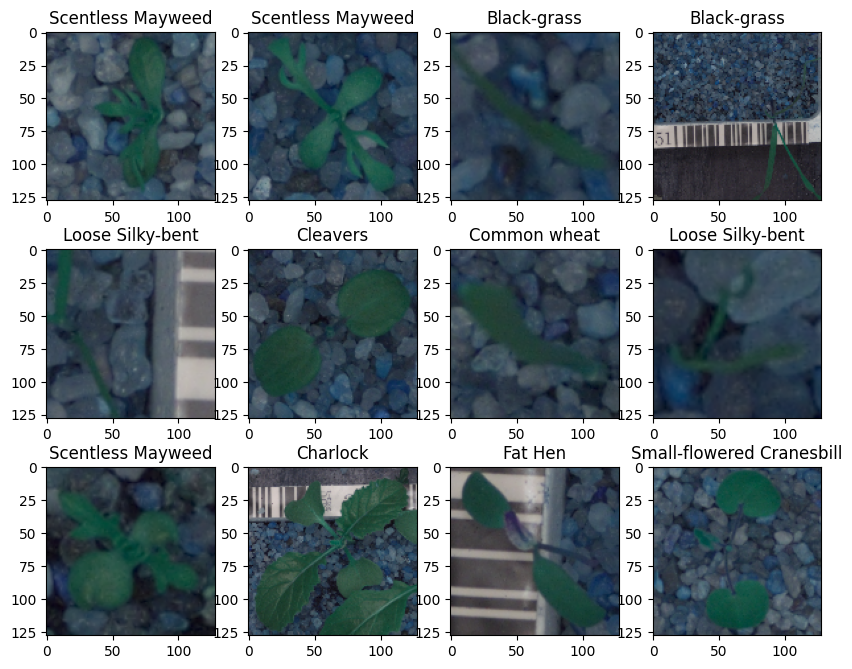

In [ ]:
# View an image for each plant type
plot_images(images=images, labels=labels)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

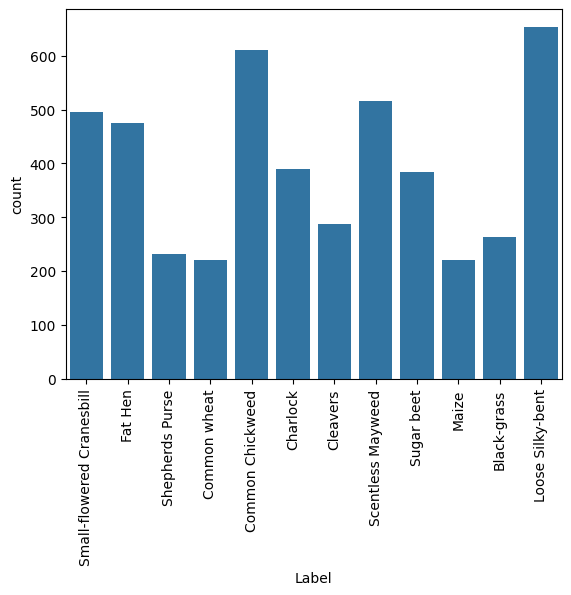

In [ ]:

# Display the distribution of the plant types. I choose not to modify the distributio
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

**Observations**

1.The labels file contains Labels for each picture

2.There are 12 types of unique plants in the labels file

3.There are some higher distributions within the plant types, but I choose to keep the data as is
and not chnage the weights.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [ ]:

# Convert the images from BGR to RGB
for i in range(len(images)):
 images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [ ]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
# Reduce file size to 64x64
import cv2

# Reduce file size to 64x64
resized_images = []
for i in range(len(images)):
    resized_images.append(cv2.resize(images[i], (64,64), interpolation=cv2.INTER_LINEAR))


In [ ]:
print(resized_images[1].shape)
print(labels.shape)

(64, 64, 3)
(4750, 1)


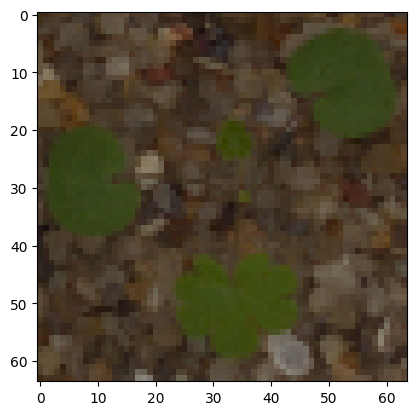

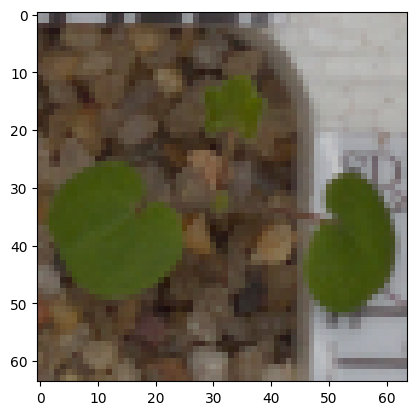

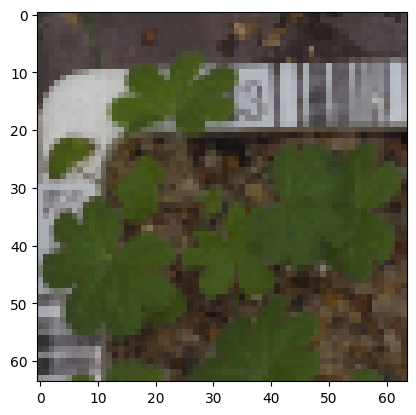

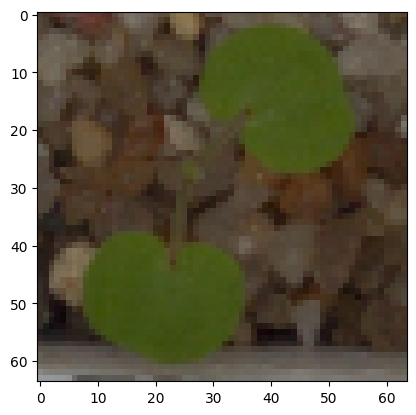

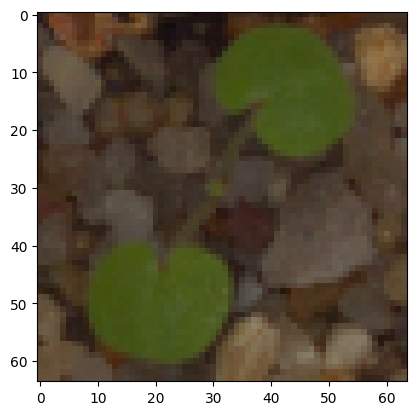

In [ ]:
# Display a few of the images to see what they look like after resize
for i in range(1,6):
 plt.imshow(resized_images[i])
 plt.show()

In [ ]:
images_decreased=[]
height = 64                    # Define the height as 64
width = 64                    # Define the width as 64
dimensions = (width, height)
for i in range(len(images)):
    images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))



**Image before resizing**

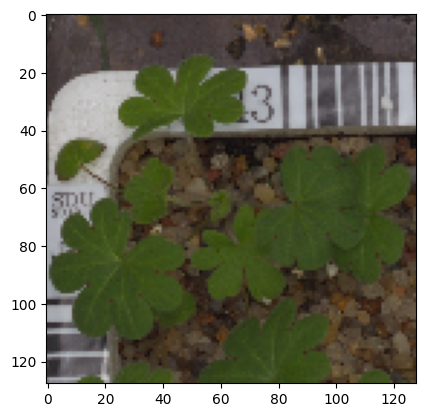

In [ ]:
plt.imshow(images[3])

**Image after resizing**

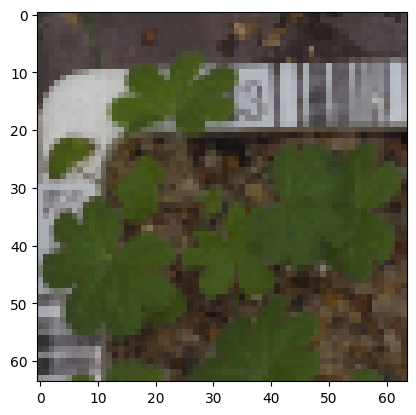

In [ ]:
plt.imshow(images_decreased[3])

Based on the output of the displayed images, we can observe the visual quality and characteristics of the resized images, confirming whether the resizing operation has been performed as expected.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(resized_images), labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3420, 1)
(380, 1)
(950, 1)
(3420, 64, 64, 3)
(380, 64, 64, 3)
(950, 64, 64, 3)


### Encode the target labels

In [ ]:
# Encode the plants
encode = LabelBinarizer()
y_train_encoded = encode.fit_transform(y_train)
y_val_encoded=encode.transform(y_val)
y_test_encoded=encode.transform(y_test)

In [ ]:
print(y_train_encoded.shape)
print(y_val_encoded.shape)
print(y_test_encoded.shape)

(3420, 12)
(380, 12)
(950, 12)


In [ ]:

print(y_test_encoded)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
y_train_encoded.shape, y_val.shape, y_test.shape

((3420, 12), (380, 1), (950, 1))

### Data Normalization

In [ ]:
# Normalize the data to 0-1 rather than 255 values
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Observations:**



* Scaled the photos to 64x64
* Created the train, test and validation sets so that test and validation was 10% each with
training using 80%
* Finaly,encoded and normalized the data, to encide the labels and to normalize the 255
range down to 0-1 values






## Model Building

In [ ]:

# Setting seed and session
backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Intializing a sequential model
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3), padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dense(12, activation='softmax'))


In [ ]:
# Used Adam and catgorical Cross due to the 12 categoies in the data
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
# I ran this model a bunch of times and the best O could come up with was epoch 23 and
model_history = model.fit(
 X_train_normalized, y_train_encoded,
 epochs=23,
 validation_data=(X_val_normalized,y_val_encoded),
 batch_size=25
)

Epoch 1/23
137/137 [==============================] - 10s 14ms/step - loss: 2.2750 - accuracy: 0.2003 - val_loss: 2.4753 - val_accuracy: 0.1632
Epoch 2/23
137/137 [==============================] - 1s 7ms/step - loss: 1.7764 - accuracy: 0.4000 - val_loss: 3.1699 - val_accuracy: 0.1632
Epoch 3/23
137/137 [==============================] - 1s 7ms/step - loss: 1.4727 - accuracy: 0.4936 - val_loss: 2.1596 - val_accuracy: 0.2763
Epoch 4/23
137/137 [==============================] - 1s 7ms/step - loss: 1.2687 - accuracy: 0.5558 - val_loss: 1.8322 - val_accuracy: 0.3342
Epoch 5/23
137/137 [==============================] - 1s 7ms/step - loss: 1.1362 - accuracy: 0.6108 - val_loss: 1.2813 - val_accuracy: 0.5711
Epoch 6/23
137/137 [==============================] - 1s 7ms/step - loss: 0.9942 - accuracy: 0.6532 - val_loss: 2.2189 - val_accuracy: 0.3395
Epoch 7/23
137/137 [==============================] - 1s 7ms/step - loss: 0.8938 - accuracy: 0.6918 - val_loss: 0.9619 - val_accuracy: 0.7079
Epoc

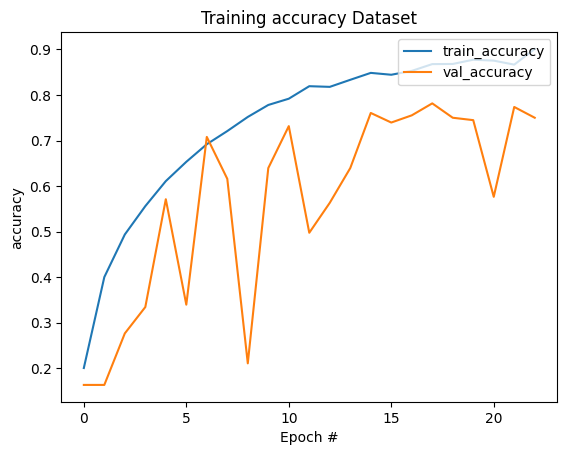

In [ ]:
# View the model accuracy.
plot_history(model_history)

In [ ]:
# Eval the model
model.evaluate(X_test_normalized,(y_test_encoded))

30/30 [==============================] - 1s 10ms/step - loss: 1.1501 - accuracy: 0.7505


[1.150146245956421, 0.7505263090133667]

In [ ]:
# Test Prediction
y_test_pred_ln = model.predict(X_test_normalized)
y_test_pred_classes_ln = np.argmax(y_test_pred_ln, axis=1)
normal_y_test = np.argmax(y_test_encoded, axis=1)

30/30 [==============================] - 0s 4ms/step


In [ ]:
# Test Accuracy
accuracy_score((normal_y_test), y_test_pred_classes_ln)

0.7505263157894737

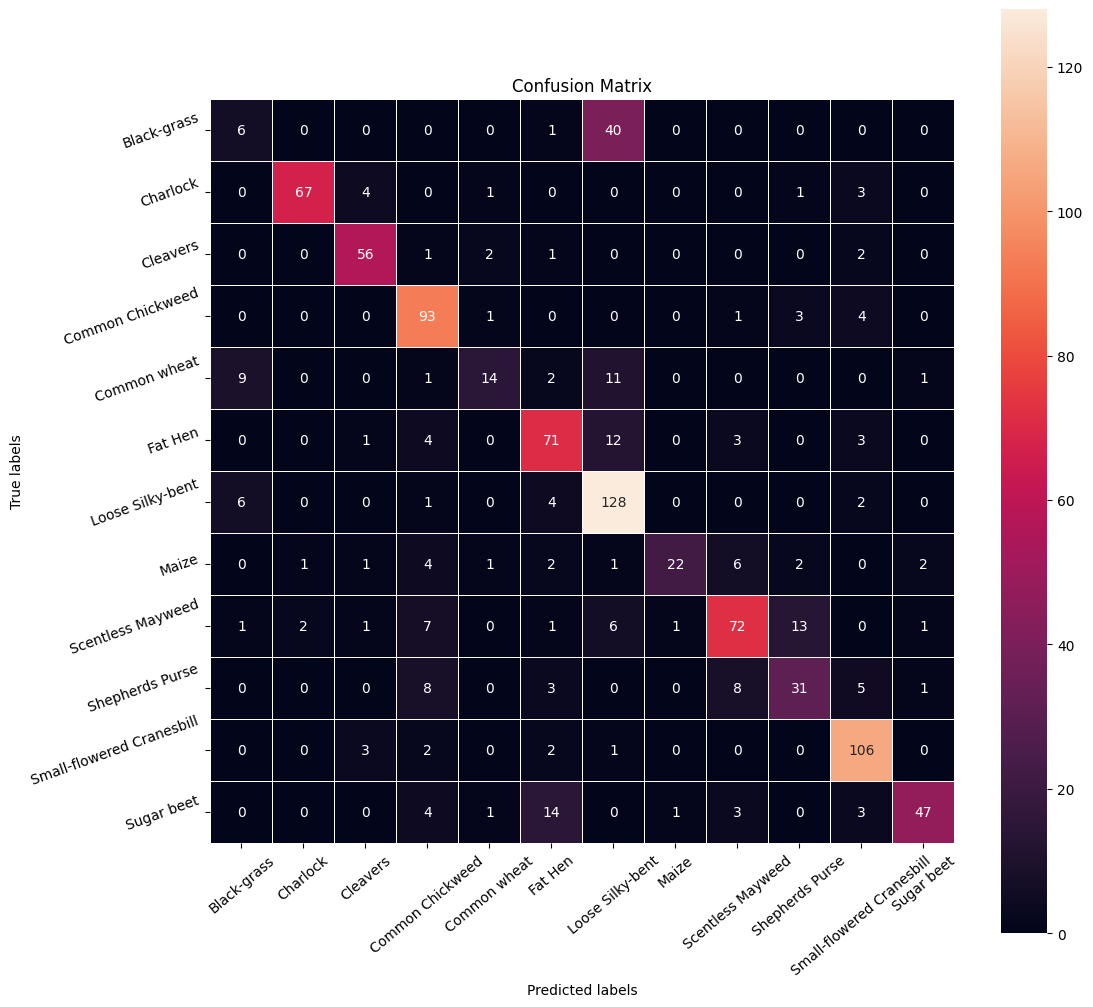

In [ ]:
# Display Matrix
f, ax = plt.subplots(figsize=(12, 12))
confusion_matrix = tf.math.confusion_matrix(normal_y_test, y_test_pred_classes_ln)
sns.heatmap(
 confusion_matrix,
 annot=True,
 linewidths=.4,
 fmt="d",
 square=True,
 ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(encode.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(encode.classes_),rotation=20)
plt.show()

In [ ]:
# Plotting the values of precision, recall and f1
print(classification_report(normal_y_test, y_test_pred_classes_ln))

              precision    recall  f1-score   support

           0       0.27      0.13      0.17        47
           1       0.96      0.88      0.92        76
           2       0.85      0.90      0.88        62
           3       0.74      0.91      0.82       102
           4       0.70      0.37      0.48        38
           5       0.70      0.76      0.73        94
           6       0.64      0.91      0.75       141
           7       0.92      0.52      0.67        42
           8       0.77      0.69      0.73       105
           9       0.62      0.55      0.58        56
          10       0.83      0.93      0.88       114
          11       0.90      0.64      0.75        73

    accuracy                           0.75       950
   macro avg       0.74      0.68      0.70       950
weighted avg       0.75      0.75      0.74       950



**Observations**
1. I choose to use the model in one of the sample in this weeks example as a starting point for
the model
2.Ran the model for many epochs and bacth sizes until I could get a good accuracy vs
perfomance
3. The model is stil overfit with accurancy mix
3. Loose silky Bent seems to be the one that has the highest error, mistakening it with black
grass and black hen the most.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Set perameters for learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
 patience=4,
verbose=1,
factor=0.3)

In [ ]:
# Setting seed and session
backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
# Apply some basic data augmentation. Rotate 20, etc.
train_datagen = ImageDataGenerator(
 rotation_range=20,
fill_mode='nearest'
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Initializing a sequential model
model2 = Sequential()
model2.add(Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3), padding='same'))
model2.add(MaxPooling2D((2,2)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2,2)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(12, activation='softmax'))
model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
# Fit new model with augmented data
history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
 batch_size=25,
shuffle=False),
epochs=30,
validation_data=(X_val_normalized,y_val_encoded))

Epoch 1/30
137/137 [==============================] - 7s 33ms/step - loss: 2.2478 - accuracy: 0.2287 - val_loss: 2.5284 - val_accuracy: 0.1632
Epoch 2/30
137/137 [==============================] - 5s 39ms/step - loss: 1.7668 - accuracy: 0.3839 - val_loss: 2.9694 - val_accuracy: 0.1632
Epoch 3/30
137/137 [==============================] - 4s 32ms/step - loss: 1.4817 - accuracy: 0.4816 - val_loss: 2.1775 - val_accuracy: 0.2974
Epoch 4/30
137/137 [==============================] - 4s 31ms/step - loss: 1.3238 - accuracy: 0.5319 - val_loss: 2.7097 - val_accuracy: 0.1316
Epoch 5/30
137/137 [==============================] - 6s 41ms/step - loss: 1.1882 - accuracy: 0.5827 - val_loss: 1.2454 - val_accuracy: 0.5842
Epoch 6/30
137/137 [==============================] - 4s 30ms/step - loss: 1.0737 - accuracy: 0.6342 - val_loss: 2.5821 - val_accuracy: 0.3289
Epoch 7/30
137/137 [==============================] - 6s 42ms/step - loss: 0.9708 - accuracy: 0.6690 - val_loss: 0.8690 - val_accuracy: 0.7053

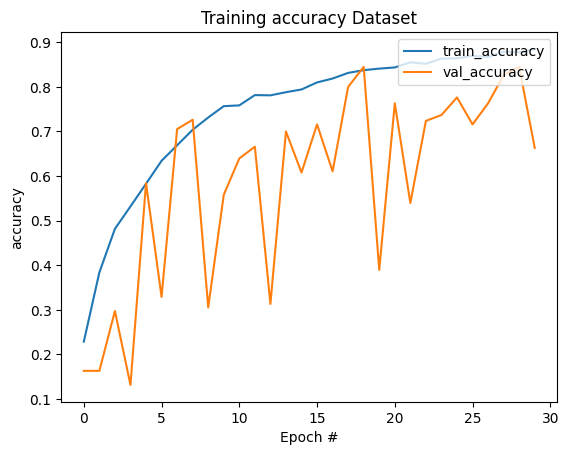

In [ ]:
plot_history(history)

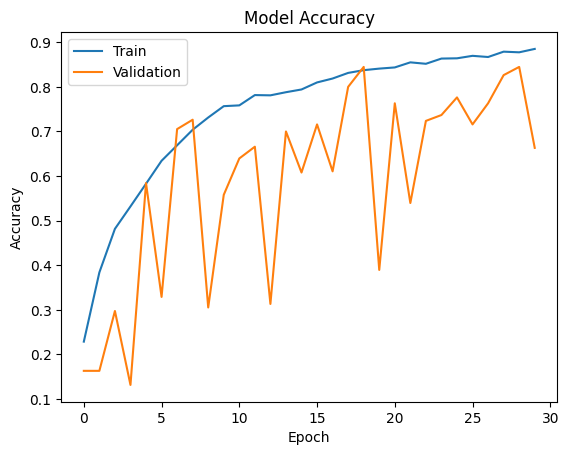

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 1.1289 - accuracy: 0.6737 - 220ms/epoch - 7ms/step


**Plotting the Confusion Matrix**

In [ ]:
y_pred = model2.predict(X_test_normalized)

30/30 [==============================] - 1s 8ms/step


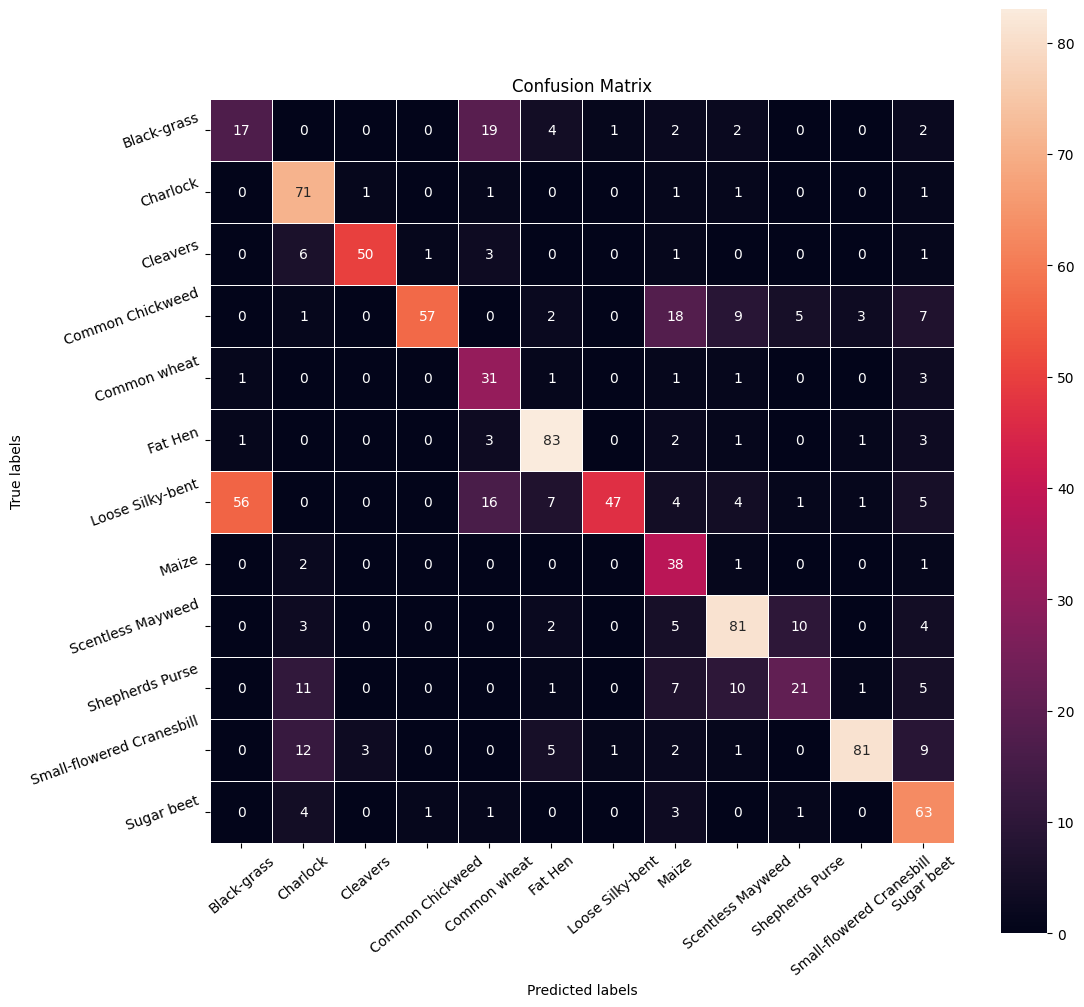

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)    # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(encode.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(encode.classes_),rotation=20)
plt.show()

**Plotting Classification Report**

In [ ]:
from sklearn import metrics

# Plotting the classification report
cr = metrics.classification_report(y_test_arg, y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.23      0.36      0.28        47
           1       0.65      0.93      0.76        76
           2       0.93      0.81      0.86        62
           3       0.97      0.56      0.71       102
           4       0.42      0.82      0.55        38
           5       0.79      0.88      0.83        94
           6       0.96      0.33      0.49       141
           7       0.45      0.90      0.60        42
           8       0.73      0.77      0.75       105
           9       0.55      0.38      0.45        56
          10       0.93      0.71      0.81       114
          11       0.61      0.86      0.71        73

    accuracy                           0.67       950
   macro avg       0.68      0.69      0.65       950
weighted avg       0.76      0.67      0.67       950



Observations:

* I choose to keep the same model structue as the first mode, and only do some data augmentation and choose differrent epoch and batch size counts
* I increase the ephochs on thismodel given the smoother increase in accuracy and improvement. If I went much more than this the time to execute took longer with not much benefit
* The fitting was reduced and accuracy increaed to 88/83 (One run of it got up to 90/87)
* In addition the accuracy curve was a lot more uniform as ephochs increaed
* As was the case with the original mode Loose Silky Bent still seems to be were most of the error is along with Fat Hen and Black grass

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

**Observations:**

* I choose the second model due to its improved accuracy, no overfitting
* The second model does take longer to run but was not too bad
* It still has issue with Loose Silky when compared to Black Grass and Fat hen

### Visualizing the prediction

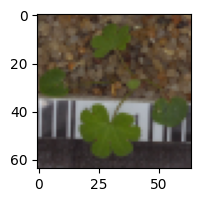

1/1 [==============================] - 0s 343ms/step
Predicted Label ['Sugar beet']
True Label Small-flowered Cranesbill


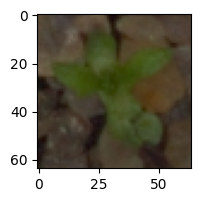

1/1 [==============================] - 0s 31ms/step
Predicted Label ['Scentless Mayweed']
True Label Scentless Mayweed


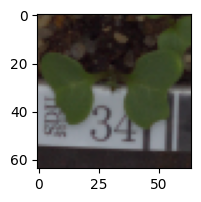

1/1 [==============================] - 0s 42ms/step
Predicted Label ['Charlock']
True Label Charlock


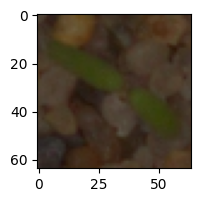

1/1 [==============================] - 0s 26ms/step
Predicted Label ['Fat Hen']
True Label Fat Hen


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', encode.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', encode.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', encode.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', encode.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', encode.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', encode.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', encode.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', encode.inverse_transform(y_test_encoded)[36])

## Actionable Insights and Business Recommendations

To improve the model's performance and address specific challenges in plant classification, particularly regarding the distinction between Black Grass, Fat Hen, and Loose Silky.

1. Increasing Sampling: Increasing the sampling of minority classes like Black Grass and Fat Hen can indeed help the model better learn the distinguishing features of these classes. This can mitigate the issue of class imbalance and improve the model's ability to differentiate between similar classes.

2. Weighting Classes: Applying class weights, especially to the minority classes like Loose Silky, can help in balancing the influence of each class during training. This can be particularly beneficial when dealing with imbalanced datasets, ensuring that the model pays more attention to the minority classes.

3. Transfer Learning: Leveraging pre-trained models through transfer learning can be advantageous, especially when working with limited data. By using models trained on larger datasets and more computational resources, you can benefit from learned features and hierarchical representations that may generalize well to your specific task.

4. Data Augmentation: Implementing additional data augmentation techniques can introduce variability into the dataset, making the model more robust to variations in input images. Techniques such as rotation, flipping, cropping, and brightness adjustment can help in creating a more diverse dataset for training.

5. Business Perspective: Considering the implications of misidentifying specific combinations of plants from a business perspective is crucial. Implementing controls or additional checks in the classification process can help mitigate the impact of misclassification, ensuring accurate identification of critical plant species.

6. By incorporating these strategies into your model development process, you can enhance the accuracy and robustness of your plant classification system, addressing both technical challenges and business requirements effectively.

_____